In [7]:
# Import 
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import os
import numpy as np
import time
import copy
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm
from random import sample
import random
import torch.optim as optim
from torch.optim import lr_scheduler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [8]:
# Get CUDA
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


The code will run on GPU.


In [9]:
# Define Hotdog data class
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/dtu/datasets1/02514/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

In [10]:
# Load data
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)),
                                      transforms.RandomRotation(degrees=50),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.ToTensor()])

train_transform1 = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor()])
            
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform1)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)


CNN

In [11]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
                nn.Conv2d(in_channels=3,out_channels=32,kernel_size=11,stride=1,padding='same'),
                nn.ReLU(),
                #nn.Dropout(0.4),
                nn.BatchNorm2d(num_features=32),
                nn.MaxPool2d(kernel_size=2),
                nn.Conv2d(in_channels=32,out_channels=64,kernel_size=7,stride=1,padding='same'),
                nn.ReLU(),
                #nn.Dropout(0.4),
                nn.BatchNorm2d(num_features=64),
                nn.MaxPool2d(kernel_size=2),
                nn.Conv2d(in_channels=64,out_channels=128,kernel_size=5,stride=1,padding='same'),
                nn.ReLU(),
                #nn.Dropout(0.4)
                )

        self.fully_connected = nn.Sequential(
                nn.Linear(32*32*128, 5000),
                nn.ReLU(),
                #nn.Dropout(0.4),
                nn.Linear(5000, 1000),
                nn.ReLU(),
                #nn.Dropout(0.4),
                nn.Linear(1000,2),
                nn.Sigmoid())
    
    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

In [12]:
############################## resnet18 ###########################
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

#Get the first minibatch
data = next(iter(train_loader))[0].cuda()
model_ft(data)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
model = Network()
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

#Get the first minibatch
data = next(iter(train_loader))[0].cuda()
#Try running the model on a minibatch
print('Shape of the output from the convolutional part', model.convolutional(data).shape)
model(data); #if this runs the model dimensions fit

Shape of the output from the convolutional part torch.Size([64, 128, 32, 32])


In [14]:
#!nvidia-smi

In [15]:
num_epochs = 10
test_im = []
targ_im = []
pred_im = []

train_accList = []
test_accList = []
for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_correct = 0
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer_ft.zero_grad()
        #Forward pass your image through the network
        output = model_ft(data)
        #Compute the loss
        loss = F.cross_entropy(output, target)
        #Backward pass through the network
        loss.backward()
        #Update the weights
        optimizer_ft.step()
        
        #Compute how many were correctly classified
        predicted = output.argmax(1)
        train_correct += (target==predicted).sum().cpu().item()
    #Comput the test accuracy
    test_correct = 0
    for data, target in test_loader:
        data = data.to(device)
        with torch.no_grad():
            output = model_ft(data)
        predicted = output.argmax(1).cpu()
        test_correct += (target==predicted).sum().item()
        
        if epoch == (num_epochs-1):
            # Save for image displaying
            test_im.append(data)
            targ_im.append(target)
            pred_im.append(predicted)
    
    train_acc = train_correct/len(trainset)
    test_acc = test_correct/len(testset)
    train_accList.append(train_acc)
    test_accList.append(test_acc)
    print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))
    

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 78.6%	 test: 50.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 92.0%	 test: 50.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 95.7%	 test: 49.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 98.2%	 test: 49.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 99.2%	 test: 49.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 99.6%	 test: 50.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 99.8%	 test: 49.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 99.9%	 test: 49.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 100.0%	 test: 49.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 100.0%	 test: 49.8%


Text(0, 0.5, 'Accuracy')

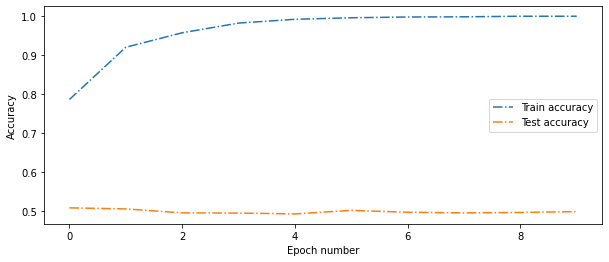

In [16]:
xran = range(epoch+1)
fig = plt.subplots(1,figsize=(10,4))
plt.plot(xran,train_accList,'-.',label='Train accuracy')
plt.plot(xran,test_accList,'-.',label='Test accuracy')
plt.legend()
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')

ValueError: num must be 1 <= num <= 20, not 21

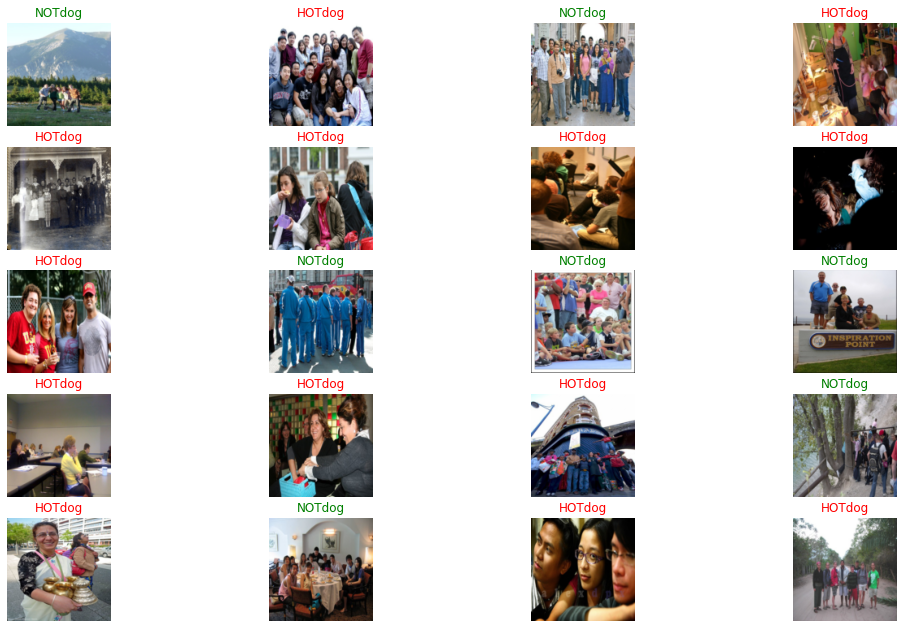

In [17]:
import random
### Lets print the test images with prediction as label (from last iteration)
# Choose random k to select random test set to display
k = random.randint(0,len(pred_im))
im_copy = test_im[k].cpu()
im_copy = im_copy.numpy()
fig = plt.subplots(figsize=(18,11))
for i in range(len(im_copy)):
    plt.subplot(5,4,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(im_copy[i,:,:,:], 0, 2), 0, 1))
    if pred_im[k][i].item() == targ_im[k][i].item():
        plt.title(['HOTdog', 'NOTdog'][pred_im[k][i].item()],color='green')
    else:
        plt.title(['HOTdog', 'NOTdog'][pred_im[k][i].item()],color='red')
    plt.axis('off')


In [ ]:
train_accList

In [ ]:
test_accList

In [ ]:
train_acc_JC = [0.6458231558378115,0.7469467513434294,0.7806546165119688,0.8031265266243283,0.8236443575964827,0.8407425500732779,0.8456277479237909,0.870542256961407,0.8851978505129457,0.8920371275036639]
train_acc_Kel = [0.6575476306790425,0.706399609184172,0.7445041524181729,0.7655105031753786,0.769418661455789,0.7860283341475329,0.7855398143624817,0.8045920859794822,0.8148510014655593,0.8128969223253542]
train_acc_Chen = [0.8419, 0.9004, 0.9274,  0.9150, 0.9210, 0.9302, 0.9388, 0.9626, 0.9561, 0.9670]
test_acc_JC = [0.6240601503759399,0.682062298603652,0.6836734693877551,0.7126745435016112,0.7013963480128894,0.6664876476906552,0.6987110633727175,0.7116004296455424,0.7040816326530612,0.7051557465091299]
test_acc_Kel = [0.611170784103115,0.7454350161117078,0.7164339419978518,0.6707841031149302,0.7706766917293233,0.771750805585392,0.757250268528464,0.7771213748657357,0.7824919441460795,0.7878625134264232]
test_acc_Chen = [0.9300, 0.9348, 0.9550,  0.9550, 0.9400, 0.9400, 0.9650, 0.9650, 0.9750, 0.9700]

xran = range(1,len(train_acc_JC)+1)

fig = plt.subplots(1, figsize=(13,7))
plt.plot(xran,train_acc_JC,'.-',label='Train, simple-CNN',color='orange')
plt.plot(xran,train_acc_Kel,'.-',label='Train, ResNet',color='green')
plt.plot(xran,train_acc_Chen,'.-',label='Train, ResNet18',color='blue')
plt.plot(xran,test_acc_JC,'-.',label='Test, simple-CNN',color='orange')
plt.plot(xran,test_acc_Kel,'-.',label='Test, ResNet',color='green')
plt.plot(xran,test_acc_Chen,'-.',label='Test, ResNet18',color='blue')
plt.legend(ncol=2,fontsize=19)
plt.title('Performance',fontsize=26)
plt.xlabel('Epoch number',fontsize=21)
plt.ylabel('Accuracy',fontsize=21)
plt.tick_params(axis='both',labelsize=19)
plt.ylim([0.53,1])

plt.savefig('performance.png')

In [ ]:
# Saliency for same images
test_count = 0
fig, axs = plt.subplots(2,4,figsize=(13,5), gridspec_kw={'height_ratios': [1, 1]})

for data, target in test_loader:
    data = data.to(device)
    data.requires_grad_()
    output = model(data)
    predicted = output.argmax(1).cpu()
    
    # Catch the output
    output_idx = output.argmax(dim=1)

    for i in range(len(target)-2):
        if target[i]== 0 and predicted[i] == 1:
            # Do backpropagation to get the derivative of the output based on the image
            output_max = output[i,output_idx[i]]
            output_max.backward(retain_graph=True)
            saliency, _ = torch.max(data.grad.data[i].abs(), dim=0) 
            saliency = saliency.reshape(size, size)
            saliency = (saliency-torch.min(saliency))/(torch.max(saliency)-torch.min(saliency))

            axs.flatten()[test_count+4].imshow(saliency.cpu().numpy(), 'gnuplot2')
            axs.flatten()[test_count+4].set_title(f'Saliency of prediction')
            axs.flatten()[test_count+4].axis('off')

            axs.flatten()[test_count].imshow(data[i].detach().cpu().numpy()[0], 'gray')
            axs.flatten()[test_count].set_title(f'target: {"hotdog" if target[i].item() == 0 else "notdog"}, pred: {"hotdog" if predicted[i].item() == 0 else "notdog"}')
            axs.flatten()[test_count].axis('off')

            
            test_count += 1
    
        if test_count == 2:
            break;
    if test_count == 2:
        break;


for data, target in test_loader:
    data = data.to(device)
    data.requires_grad_()
    output = model(data)
    predicted = output.argmax(1).cpu()

    # Catch the output
    output_idx = output.argmax(dim=1)

    for i in range(len(target)):
        if target[i]==predicted[i]:
            # Do backpropagation to get the derivative of the output based on the image
            output_max = output[i,output_idx[i]]
            output_max.backward(retain_graph=True)
            saliency, _ = torch.max(data.grad.data[i].abs(), dim=0) 
            saliency = saliency.reshape(size, size)
            saliency = (saliency-torch.min(saliency))/(torch.max(saliency)-torch.min(saliency))
            axs.flatten()[test_count+4].imshow(saliency.cpu().numpy(), 'gnuplot2')
            axs.flatten()[test_count+4].set_title(f'Saliency of prediction')
            axs.flatten()[test_count+4].axis('off')

            axs.flatten()[test_count].imshow(data[i].detach().cpu().numpy()[0], 'gray')
            axs.flatten()[test_count].set_title(f'target: {"hotdog" if target[i].item() == 0 else "notdog"}, pred: {"hotdog" if predicted[i].item() == 0 else "notdog"}')
            axs.flatten()[test_count].axis('off')
            
            test_count += 1
    
        if test_count == 4:
            break;
    if test_count == 4:
        break;
#plt.subplots_adjust(left=0.02, right=0.98, top=0.98, bottom=0.02, hspace=0.2, wspace=0.02)
plt.tight_layout()
#plt.savefig('saliency.png')